In [67]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [6]:
# loading the data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

0
0
[0 1 2 3 4 5 6 7 8 9]
255


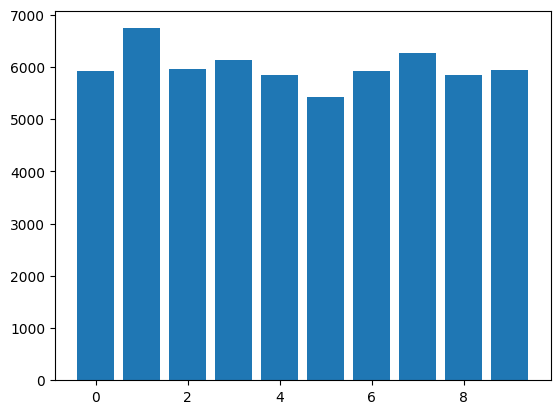

In [41]:
# data exploration
train_images.shape
# we have 60,000 observations, each 28x28

train_labels.shape
# labels are 1D (i.e. a scalar)

print(sum(sum(sum(np.isnan(train_images)))))
print(sum(sum(sum(np.isnan(test_images)))))
# no NaNs within the training data set or test data set

unique_vals, counts = np.unique(train_labels, return_counts= True)
print(unique_vals)
plt.bar(unique_vals, counts)
# we have 10 unique classes -> our model should have 10 output nodes in the final layer
# relatively evenly in terms of class balance

print(np.max(train_images[0]) - np.min(train_images[0]))
# range of values is 0 to 255. Looking at mnist data set, this represents the value of
# intensity of that specific pixel (0 being fully white, 255 being fully black)

# transform for performance sake
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

In [70]:
# defining the model

# our inputs are of the form 28x28x1 (since it's greyscale, we only have a depth of 1)
inputs = keras.Input(shape=(28, 28, 1))

# feed into a Dense network
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Flatten()(x) # flattening is done so that it can attach to the Dense

# output layer has 10 nodes as we have 10 classes
# softmax allows for the output to be interpreted as a probability
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 86s 183ms/step - loss: 0.3680 - accuracy: 0.8932
Epoch 2/5
469/469 [==============================] - 86s 184ms/step - loss: 0.2932 - accuracy: 0.9177
Epoch 3/5
469/469 [==============================] - 85s 181ms/step - loss: 0.2748 - accuracy: 0.9227
Epoch 4/5
469/469 [==============================] - 85s 182ms/step - loss: 0.2517 - accuracy: 0.9301
Epoch 5/5
469/469 [==============================] - 85s 181ms/step - loss: 0.2266 - accuracy: 0.9368


In [58]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

# dummy classifier 
unique_vals_test, counts_test = np.unique(test_labels, return_counts= True)
print(np.max(counts_test)/test_labels.shape[0])

313/313 [==============================] - 5s 17ms/step - loss: 0.3003 - accuracy: 0.9173
Test accuracy: 0.917
0.1135


Accuracy is at 0.917. This is the number of correct labels predicted by the model over the total number of observations in the data set. Given that our classes are relatively balanced, the dummy classifier (where it simply predicts the mode of the classes), we would attain an accuracy of 0.114. Our model does significantly better than a dummy classifier!

In [76]:
y_pred = model.predict(test_images)

313/313 [==============================] - 5s 15ms/step


array([7, 2, 1, ..., 4, 5, 6])

In [81]:
y_pred_output = np.apply_along_axis(np.argmax, 1, y_pred)
res = tf.math.confusion_matrix(test_labels, y_pred_output, num_classes= 10)
print(res)

tf.Tensor(
[[ 954    0    2    1    1    8    7    3    4    0]
 [   0 1120    4    1    0    1    4    1    4    0]
 [   5    2  955    8   10    6    8   13   22    3]
 [   2    0   19  918    1   23    2   18   21    6]
 [   1    0    7    0  935    0    2    5    9   23]
 [   7    1    3   27    9  801   11   11   19    3]
 [   7    3   12    1   10   16  901    3    5    0]
 [   1    7   20    3    5    1    0  979    0   12]
 [   5    6   10   13   12   18    5   10  887    8]
 [   8    7    1   12   30    5    0   33    9  904]], shape=(10, 10), dtype=int32)


(I'm assuming that the columns represent the actual labels, while the rows represent the predicted labels. The documentation of the confusion matrix seems quite sparse in details. https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix)

It does not seem like our model is predicting any specific class more wrongly than any other classes. The maximum number of errors for 1 specific class is 30, out of 10,000 test cases.

(I've unfortunately mismanaged my time a bit, so I don't really have the time to figure out the precision/recall for multiclass classification tasks. Although I have found this nice stackexchange question that seems to address my question:
https://stats.stackexchange.com/questions/179835/how-to-build-a-confusion-matrix-for-a-multiclass-classifier)